# Importe

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import statsmodels.api as sm
from uncertainties import ufloat, unumpy as unp
import uncertainties
from uncertainties.unumpy import (nominal_values as n,std_devs as s)
import scipy.stats as stats


plt.style.use('classic')
plt.rc('text',usetex=True)
plt.rc('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen

# Eigen definierte Funktionen

In [3]:
def reg(x,a,b):
    f = x * a +b
    return f

def gew_mean(x_data, x_err):
    x_mean = np.sum(x_data/x_err**2)/np.sum(1/x_err**2)
    return x_mean

def chi_sq(x_data,y_data,  a,b, y_err):
    n = len(y_data)
    chi = (y_data- reg(x_data, a,b))**2/y_err**2
    chi_sum = np.sum(chi)
    chi_red = chi_sum/(n-2)
    y_mean = gew_mean(y_data,y_err)
    R_sq = np.sum(( reg(x_data, a,b)-y_mean)**2)/np.sum(( y_data-y_mean)**2)
    return round(chi_sum,1), round(chi_red,1), round(R_sq,3)

def U_r(k,e,u_k,u_e):
    u = 1/(np.sqrt(2)*(k-e)**2) * np.sqrt(u_k**2 * (k**2-2*k*e-e**2)**2 + u_e**2 * (e**2-2*k*e-k**2)**2)
    return u

def reg1(x,a,b):
    f = 1/(a*x+b)
    return f

def reg2(x,a,b):
    f = a/x + b
    return f

def u_e_m_r(UA, k ,a , u_UA, u_k , u_a):
    em = a**2/(2* U_A * k**2)
    u = 2/(a*k)**2 * np.sqrt(u_UA**2 + 4*UA**2 *(u_a**2/a**2+ u_k**2/k**2))
    return em, u

def u_em_Uk(UA, k, a, d, u_UA, u_k, u_a):
    em =  a**2/(2* UA * k**2 * d**2)
    u_em = 1/(2*d**2) *np.sqrt(4*a**2 * u_a**2 /(2* UA * k**2)**2 + 4 * a**4 / ( UA * k**2)**2 * (u_k**2/k**2+ u_UA**2/UA**2))
    return em, u_em

# Daten

## Anodenspannungen

In [4]:
U_A_3kV = 3e3  # V
U_A_4kV = 4e3
U_A_5kV = 5e3

In [5]:
U_A = np.ones(30)
for i in range(30):
    if i < 10:
        U_A[i] = U_A[i] * U_A_3kV
    elif (i>=10 and i<20):
        U_A[i] = U_A[i] * U_A_4kV
    else:
        U_A[i] = U_A[i] * U_A_5kV

## Fehlerrechnung von $U_A$

In [6]:
ua_err = U_A * 0.025
U_A_err = unp.uarray(U_A, ua_err)

## Messdaten

In [7]:
A5 = pd.read_csv('A5.txt', sep='\t')
A6 = pd.read_csv('A6.txt', sep='\t')
A7 = pd.read_csv('A7.txt', sep='\t')

In [8]:
A5.head()

,I,B,r,B1
0,0.163,0.35,0.0,1.16
1,0.207,0.44,1.0,1.17
2,0.251,0.52,1.7,1.16
3,0.305,0.64,2.7,1.15
4,0.364,0.74,3.0,1.16


In [9]:
A6.head()

,I,e,u_e
0,0.006,7.9,0.2
1,0.220,6.0,0.1
2,0.411,4.9,0.1
3,0.519,4.2,0.1
4,0.620,3.8,0.1


In [10]:
A7.head()

,I,U_k
0,0.097,60.89
1,0.147,83.88
2,0.293,133.08
3,0.450,232.80
4,0.490,242.33


# Aufgabe 1
Für den Kreisbahnradius $r$ nach (12) sind vor dem eigentlichen Experiment die notwendigen
Berechnungen für die Unsicherheitsbetrachtung vorzubereiten: Welche relative Unsicherheit $ \frac{u_r}{r}$ kann (realistisch betrachtet) erzielt werden?

$$ r = \frac{k^2 + e^2}{\sqrt{2}(k-e)} \\
\partial_k r =  \frac{k^2-2 k e - e^2}{\sqrt{2}(k-e)^2}\\
\partial_e r = -\frac{e^2-2 k e - k^2}{\sqrt{2}(k-e)^2}\\
u_r = \frac{1}{\sqrt{2}(k-e)^2} \sqrt{u_k^2\cdot (k^2-2 k e - e^2)^2 + u_e^2 \cdot (e^2-2 k e - k^2)^2}$$

# Aufgabe 2
Noch vor dem Experiment ist aus den o.a. Herstellerangaben zur verwendeten Helmholtz-Spule
gemäß (10) deren Koeffizient $k$ für die später erforderliche Abhängigkeit $B(I)$ zu berechnen.

$$(10): \hspace{3mm} B(I) = \mu_0 \frac{N I }{2\cdot R} \left(\frac{4}{5}\right)^{3/2}\\
k = \mu_0 \frac{N  }{2\cdot R} \left(\frac{4}{5}\right)^{3/2}$$

In [11]:
mu = 4 * np.pi * 1e-7   # N/A^2
R = 136/(2*1000)  # 136 mm /(2* 1000), 1000 ist umrechnungsfaktor zwischen mm und m, EINHEIT: m
N = 320
k_ber = mu * N /(2*R)*(4/5)**(3/2)
print(f'k: {k_ber}')
k = n(k_ber)
u_k = s(k_ber)
print(k)
print(u_k)

k: 0.0021157089072310897
0.0021157089072310897
0.0


In [12]:
k_n = 0.0023978
u_k_n = 0.000020

# Aufgabe 3 
Die Versuchsbeschaltung ist bereits vorgenommen und soll nur überprüft werden: Fertigen Sie
mit Versuchsbeginn eine Schaltskizze (Mess-Protokoll!) an und überlegen Sie, ob richtig bzw.
sinnvoll verkabelt wurde. Lassen Sie erforderlichenfalls die Beschaltung von der Versuchsbetreuung
nachprüfen, noch bevor Sie Spannung anlegen bzw. die Versorgungsgeräte einschalten!

# Aufgabe 4

Notieren Sie sich in Ihrem Messprotokoll alle versuchsrelevanten Daten der verwendeten Messmittel
bzw. –geräte!

# Aufgabe 5
Am separaten Messplatz ist für eine dort installierte gleichartige Helmholtz-Spule mithilfe eines
Teslameters und der zugehörigen axialen Hall-Sonde (Auflösung von 0,01 mT und 2% Genauigkeit)
die räumliche Homogenität des Magnetfeldes qualitativ abzutasten bzw. zu untersuchen.
Ferner soll für den Ort genau in der Mitte zwischen beiden Ringspulen die spezifische Abhängigkeit
$B(I)=kI$ in einem Intervall der Stromstärke $I=0..2$A (Bei höheren Strömen oberhalb
von 1 A beachte man die Herstellerhinweise!) mit ausreichend vielen Messwerten gemessen,
grafisch in einem Diagramm dargestellt und daraus mithilfe einer gewichteten Regression
der Koeffizient $k $ einschließlich seiner Unsicherheit bestimmt werden. Man beachte dabei, ob die
beiden Ringspulen in Reihe oder parallel geschaltet sind. Das so gewonnene Ergebnis ist mit
dem aus Aufgabe 2 zu vergleichen.

In [13]:
A5

,I,B,r,B1
0,0.163,0.35,0.0,1.16
1,0.207,0.44,1.0,1.17
2,0.251,0.52,1.7,1.16
3,0.305,0.64,2.7,1.15
4,0.364,0.74,3.0,1.16
5,0.425,0.89,3.7,1.12
6,0.475,0.98,4.0,1.07
7,0.606,1.29,4.5,1.11
8,0.650,1.49,5.2,0.93
9,0.765,1.60,NaN,NaN


## Fehlerrechnung

In [14]:
# für klein r
u_r = np.ones(9)*0.05* 1e-2
r = np.array(A5['r'][:9]) * 1e-2
r_err = unp.uarray(r, u_r)

# Strom
i_err = np.array(A5['I'])*0.009
I5 = np.array(A5['I'])
I5_err = unp.uarray(I5,i_err)

# FLussdichte
# print(len(A5['B']))
# print(len(A5['B']))
B5 = np.array(A5['B'])
u_B =np.sqrt((np.ones(10)*0.01)**2+ (B5* 0.02)**2)
B5_err = unp.uarray(B5,u_B)


# print(len(B5_r))
# print(len(u_B))
B5_r = np.array(A5['B1'])
u_Br =np.sqrt((np.ones(10)*0.01)**2+ (B5_r* 0.02)**2)
B5_r_err = unp.uarray(B5_r[:9], u_Br[:9])
print(len(B5_r_err))
print(len(r_err))
# A5['B1']

9
9


## Visualisierung

In [15]:
plt.errorbar(n(I5_err),n(B5_err), xerr= s(I5_err), yerr= s(B5_err), fmt='.k',label='Messdaten')
plt.xlabel('I [A]')
plt.ylabel(r'B [$\Omega$]')
plt.legend()

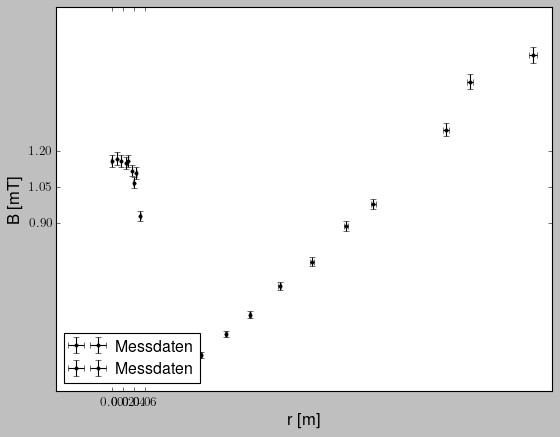

In [16]:
plt.errorbar(n(r_err),n(B5_r_err), xerr= s(r_err), yerr= s(B5_r_err), fmt='.k',label='Messdaten')
plt.xlabel('r [m]')
plt.ylabel(r'B [mT]')
plt.legend(loc=3)
plt.yticks([0.9, 1.05,1.20])
plt.xticks(np.arange(0,0.061,0.02))
# plt.savefig('Radialefeldverteilung_gemessen.pdf',dpi=600)
plt.show()

## Gewichtete Regression

In [17]:
# help(curve_fit)

In [18]:
# Regression mit scipy
pop, cov = curve_fit(reg, n(I5_err),n(B5_err),sigma= s(B5_err))
a5,b5 = pop
da5, db5 = np.sqrt(np.diag(cov))
print(f'a: {ufloat(a5,da5)}')
print(f'b: {ufloat(b5,db5)}')

a: 2.14+/-0.06
b: -0.009+/-0.019


In [19]:
# Regression mit statsmodels
y=n(B5_err)
x_zunahme=sm.add_constant(n(I5_err))
results=sm.WLS(y,x_zunahme,sigma=s(B5_err)).fit()#,sigma=yerr
print('''
Lineare Regression
''')
print(results.summary())


Lineare Regression

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            WLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     997.6
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           1.10e-09
Time:                        16:56:17   Log-Likelihood:                 18.700
No. Observations:                  10   AIC:                            -33.40
Df Residuals:                       8   BIC:                            -32.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0227      0.03

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['sigma']
  warnings.warn(msg, ValueWarning)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [20]:
# chi^2
chi_norm, chi_nu ,R_sqq= chi_sq(n(I5_err),n(B5_err), a5,b5, s(B5_err)) #y_data, x_data, a,b, y_err
print(chi_norm)
print(chi_nu)
print(R_sqq)

18.4
2.3
0.96


### Plot

In [21]:
x_reg = np.arange(0.1, 0.86, 0.25)
y_reg = reg(x_reg, a5,b5)

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(n(I5_err),n(B5_err), xerr= s(I5_err), yerr= s(B5_err), fmt='.k',label='Messdaten')
ax.plot(x_reg, y_reg, label=r'Fit: $B(I) = a\cdot I +b$')

# Für die Parameter
par1, = ax.plot([],[],' ')
par2, = ax.plot([],[],' ' )
par3, = ax.plot([],[],' ')
par4, = ax.plot([],[],' ' )

leg1= ax.legend(loc=2)
chi1=r'$\chi_{\nu}^{2}$'+f'$={chi_nu}$'

ax.set_xlabel('I [A]')
ax.set_ylabel(r'B [mT]')
leg2=ax.legend([par1,par2,par3,par4],
               [fr'$a=({round(a5,2)}\pm {round(da5,2)})$ mT/A',
                fr'$b =({round(b5,3)}\pm {round(db5,3)})$ mT',
               chi1,
               fr'$R^{2}=0.992$'],
              loc=4)
ax.add_artist(leg1)
plt.xticks(np.arange(0.1,0.91, 0.2))
plt.yticks(np.arange(0.2, 2.1, 0.45))
plt.show()
# plt.savefig('A5.pdf',dpi=600)

([<matplotlib.axis.YTick at 0x1c593be9df0>,
 [Text(0, 0.2, '$\\mathdefault{0.20}$'),
  Text(0, 0.65, '$\\mathdefault{0.65}$'),
  Text(0, 1.1, '$\\mathdefault{1.10}$'),
  Text(0, 1.55, '$\\mathdefault{1.55}$'),
  Text(0, 2.0, '$\\mathdefault{2.00}$')])

# Aufgabe 6
Für drei fest eingestellte Anodenspannungen $U_A$ von 3 kV, 4 kV und 5 kV ist jeweils die charakteristische
Abhängigkeit (5) zwischen Kreisbahnradius und eingestelltem Magnetstrom in der
abgewandelten Form $r(I) = \frac{1}{I}$
für mehrere Messwertpaare aufzunehmen, im Diagramm mit geeigneter Skalierung grafisch darzustellen und über eine geeignete Modellfunktion die spezifische
Elektronenladung mit ihrer Unsicherheit zu bestimmen. Die drei gewonnenen Ergebnisse sind
auf innere Konsistenz zu prüfen und mit dem Referenzwert zu vergleichen.

$$ r(B) = \sqrt{\frac{2 \cdot U_A}{e/m}} \frac{1}{B} \\
r = \frac{k^2+ e^2}{\sqrt{2}(k+e)}\\
B= k\cdot I$$


## Meine Vorgehensweise

In [23]:
A6.head()

,I,e,u_e
0,0.006,7.9,0.2
1,0.220,6.0,0.1
2,0.411,4.9,0.1
3,0.519,4.2,0.1
4,0.620,3.8,0.1


### Fehlerrechnung

In [24]:
# e
e = np.array(A6['e'])
u_e = np.array(A6['u_e'])
print(u_e)
test = np.array([0.1, 0.1, 0.1, 0.1,0.1, 0.1,0.1, 0.1,0.1, 0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])*0
u_e = u_e + test
print(u_e)
e_err = unp.uarray(e,u_e)
print(e_err)
# Strom
I6 = np.array(A6['I'])
u_i = np.array(A6['I'])*0.009
I6_err = unp.uarray(I6, u_i)

[0.2  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.05 0.1  0.3  0.1  0.1  0.2
 0.2  0.2  0.1  0.1  0.1  0.1  0.4  0.3  0.1  0.1  0.2  0.2  0.2  0.2
 0.1  0.1 ]
[0.2  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.05 0.1  0.3  0.1  0.1  0.2
 0.2  0.2  0.1  0.1  0.1  0.1  0.4  0.3  0.1  0.1  0.2  0.2  0.2  0.2
 0.1  0.1 ]
[7.9+/-0.2 6.0+/-0.1 4.9+/-0.1 4.2+/-0.1 3.8+/-0.1 3.1+/-0.1 2.5+/-0.1
 2.1+/-0.1 1.6+/-0.05 1.3+/-0.1 7.9+/-0.3 6.7+/-0.1 6.1+/-0.1 5.6+/-0.2
 5.1+/-0.2 4.3+/-0.2 3.7+/-0.1 3.4+/-0.1 3.0+/-0.1 2.6+/-0.1 7.9+/-0.4
 6.3+/-0.3 5.9+/-0.1 5.8+/-0.1 5.3+/-0.2 4.7+/-0.2 4.4+/-0.2 3.9+/-0.2
 3.4+/-0.1 2.8+/-0.1]


### Berechnung von r und B

In [25]:
r_err = (ufloat(8,0.05)**2+e_err**2)/(np.sqrt(2)* (ufloat(8,0.05)-e_err))
# print(r_err)
B_err  = k_ber * I6_err
# print(B_err)

#### Fehler von r

In [26]:
# help(unp)

In [27]:
u_r_A6=U_r(8,e,0.05,u_e)

In [28]:
print(u_r_A6)

[1.86306393e+03 2.27293863e+00 8.82504466e-01 5.58423651e-01
 4.42955917e-01 3.06337082e-01 2.29434683e-01 1.91131491e-01
 8.12500000e-02 1.34935275e-01 2.75070305e+03 5.59698542e+00
 2.53325471e+00 3.02157111e+00 2.01934795e+00 1.18238369e+00
 4.19140217e-01 3.57043793e-01 2.91496141e-01 2.40428110e-01
 3.64689886e+03 9.23088739e+00 2.04946355e+00 1.85623415e+00
 2.35367073e+00 1.52466701e+00 1.25729823e+00 9.35871577e-01
 3.57043793e-01 2.64431921e-01]


In [29]:
r_berr =unp.uarray((8**2+e**2)/(np.sqrt(2)* (8-e)),u_r_A6)
# print(r_berr)

#### Relativer Fehler von r

In [30]:
u_r_A6/((8**2+e**2)/(np.sqrt(2)* (8-e)))*100

array([208.43052628,   6.42884126,   4.39603946,   3.67586372,
         3.35418653,   2.88385773,   2.54033171,   2.33120071,
         1.10485435,   1.94632802, 307.73527043,   9.44984158,
         6.72549158,  10.7545642 ,   9.20096529,   7.50021733,
         3.28078421,   3.07398941,   2.82354654,   2.59481366,
       407.99729655,  21.4027953 ,   6.159899  ,   5.91483545,
         9.75915003,   8.2651594 ,   7.67888384,   6.85070236,
         3.07398941,   2.70686065])

### Variablen aufstellen

In [31]:
x1 = I6_err[:10]
x2 = I6_err[10:20]
x3 = I6_err[20:30]

y1 =r_err[:10]
y2 = r_err[10:20]
y3 = r_err[20:30]

y11 =r_berr[:10]
y22 = r_berr[10:20]
y33 = r_berr[20:30]

### Visualisierung

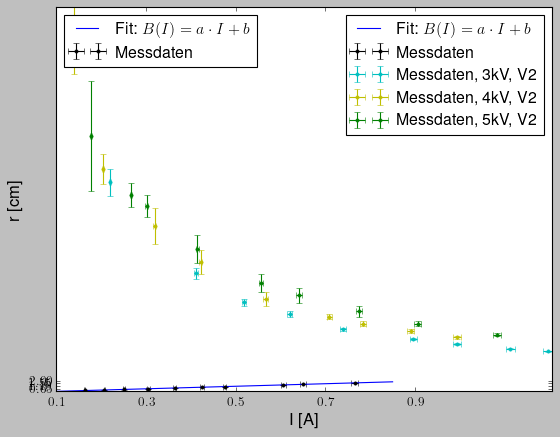

In [32]:
# plt.errorbar(n(x1),n(y1), xerr= s(x1), yerr= s(y1), fmt='.k',label='Messdaten, 3kV')
plt.errorbar(n(x1)[1:],n(y1)[1:], xerr= s(x1)[1:], yerr= s(y11)[1:], fmt='.c',label='Messdaten, 3kV, V2')
# plt.errorbar(n(x2),n(y2), xerr= s(x2), yerr= s(y2), fmt='.r',label='Messdaten, 4kV')
plt.errorbar(n(x2)[1:],n(y2)[1:], xerr= s(x2)[1:], yerr= s(y22)[1:], fmt='.y',label='Messdaten, 4kV, V2')
# plt.errorbar(n(x3),n(y3), xerr= s(x3), yerr= s(y3), fmt='.b',label='Messdaten, 5kV')
plt.errorbar(n(x3)[1:],n(y33)[1:], xerr= s(x3)[1:], yerr= s(y33)[1:], fmt='.g',label='Messdaten, 5kV, V2')
plt.xlabel('I [A]')
plt.ylabel(r'r [cm]')
# plt.xticks(np.arange(-0.01, 1.41, 0.35))
# plt.yticks(np.arange(0,7.1, 3.5))
plt.legend()
plt.show()

### gewichtete Regression

In [33]:
# Regression mit scipy
pop, cov = curve_fit(reg, n(x1),n(y11),sigma= s(y11))
a_x1,b_x1 = pop
da_x1, db_x1 = np.sqrt(np.diag(cov))
print(f'a1: {ufloat(a_x1,da_x1)}')
print(f'b1: {ufloat(b_x1,db_x1)}')


# Regression mit scipy
pop, cov = curve_fit(reg, n(x2),n(y22),sigma= s(y22))
a_x2,b_x2 = pop
da_x2, db_x2 = np.sqrt(np.diag(cov))
print(f'a2: {ufloat(a_x2,da_x2)}')
print(f'b2: {ufloat(b_x2,db_x2)}')

# Regression mit scipy
pop, cov = curve_fit(reg, n(x3),n(y33),sigma= s(y33))
a_x3,b_x3 = pop
da_x3, db_x3 = np.sqrt(np.diag(cov))
print(f'a3: {ufloat(a_x3,da_x3)}')
print(f'b3: {ufloat(b_x3,db_x3)}')

a1: -11.1+/-1.7
b1: 19.8+/-1.9
a2: -18+/-4
b2: 27+/-4
a3: -20.6+/-3.0
b3: 31.4+/-2.9


In [34]:
y=n(y1)
x_zunahme=sm.add_constant(n(x1))
results=sm.WLS(y,x_zunahme,sigma=s(y1)).fit()#,sigma=yerr
print('''
Lineare Regression
''')
print(results.summary())


Lineare Regression

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.385
Model:                            WLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     5.016
Date:                Sat, 01 Mar 2025   Prob (F-statistic):             0.0555
Time:                        16:56:25   Log-Likelihood:                -67.518
No. Observations:                  10   AIC:                             139.0
Df Residuals:                       8   BIC:                             139.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        399.4066    151.63

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['sigma']
  warnings.warn(msg, ValueWarning)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [35]:
y=n(y2)
x_zunahme=sm.add_constant(n(x2))
results=sm.WLS(y,x_zunahme,sigma=s(y2)).fit()#,sigma=yerr
print('''
Lineare Regression
''')
print(results.summary())


Lineare Regression

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.313
Model:                            WLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     3.640
Date:                Sat, 01 Mar 2025   Prob (F-statistic):             0.0928
Time:                        16:56:25   Log-Likelihood:                -67.986
No. Observations:                  10   AIC:                             140.0
Df Residuals:                       8   BIC:                             140.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        340.3612    143.01

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['sigma']
  warnings.warn(msg, ValueWarning)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [36]:
y=n(y3)
x_zunahme=sm.add_constant(n(x3))
results=sm.WLS(y,x_zunahme,sigma=s(y3)).fit()#,sigma=yerr
print('''
Lineare Regression
''')
print(results.summary())


Lineare Regression

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.305
Model:                            WLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     3.509
Date:                Sat, 01 Mar 2025   Prob (F-statistic):             0.0979
Time:                        16:56:25   Log-Likelihood:                -68.040
No. Observations:                  10   AIC:                             140.1
Df Residuals:                       8   BIC:                             140.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        337.7743    144.19

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['sigma']
  warnings.warn(msg, ValueWarning)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [37]:
nu = r'$\nu$'
chi_norm1, chi_nu1 ,R_sqq1= chi_sq(n(x1),n(y1), a_x1,b_x1, s(y1)) #y_data, x_data, a,b, y_err
print('\n für x1')
print(fr'$\chi^2$:{chi_norm1}')
print(fr'$\chi^2_{nu}$: {chi_nu1}')
print(fr'$R^2$: {R_sqq1}')

chi_norm2, chi_nu2 ,R_sqq2= chi_sq(n(x2),n(y2), a_x2,b_x2, s(y2)) #y_data, x_data, a,b, y_err
print('\n für x2')
print(fr'$\chi^2$:{chi_norm2}')
print(fr'$\chi^2_{nu}$: {chi_nu2}')
print(fr'$R^2$: {R_sqq2}')

chi_norm3, chi_nu3 ,R_sqq3= chi_sq(n(x3),n(y3), a_x3,b_x3, s(y3)) #y_data, x_data, a,b, y_err
print('\n für x3')
print(fr'$\chi^2$:{chi_norm3}')
print(fr'$\chi^2_{nu}$: {chi_nu3}')
print(fr'$R^2$: {R_sqq3}')


 für x1
$\chi^2$:117.6
$\chi^2_$\nu$$: 14.7
$R^2$: 0.0

 für x2
$\chi^2$:90.4
$\chi^2_$\nu$$: 11.3
$R^2$: 0.001

 für x3
$\chi^2$:44.2
$\chi^2_$\nu$$: 5.5
$R^2$: 0.002


#### Plot

In [38]:
x_reg = np.arange(-0.01, 1.40, 0.35)
y1_reg = reg(x_reg, a_x1, b_x1)
y2_reg = reg(x_reg, a_x2, b_x2)
y3_reg = reg(x_reg, a_x3, b_x3)

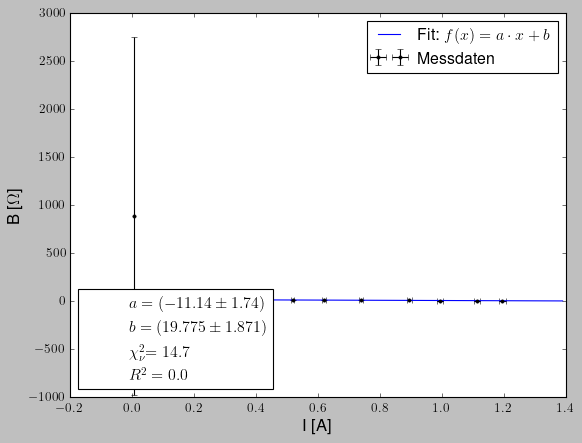

In [39]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(n(x1),n(y1), xerr= s(x1), yerr= s(y1), fmt='.k',label='Messdaten')
ax.plot(x_reg, y1_reg, label=r'Fit: $f(x) = a\cdot x +b$')

# Für die Parameter
par1, = ax.plot([],[],' ')
par2, = ax.plot([],[],' ' )
par3, = ax.plot([],[],' ')
par4, = ax.plot([],[],' ' )

leg1= ax.legend(loc=1)
chi1=r'$\chi_{\nu}^{2}$'+f'$={chi_nu1}$'

ax.set_xlabel('I [A]')
ax.set_ylabel(r'B [$\Omega$]')
leg2=ax.legend([par1,par2,par3,par4],
               [fr'$a=({round(a_x1,2)}\pm {round(da_x1,2)})$ ',#
                fr'$b =({round(b_x1,3)}\pm {round(db_x1,3)})$',#
               chi1,
               fr'$R^{2}={R_sqq1}$'],
              loc=3)
ax.add_artist(leg1)
# plt.xticks(np.arange(0.1,0.91, 0.2))
# plt.yticks(np.arange(0.2, 2.1, 0.45))
plt.show()

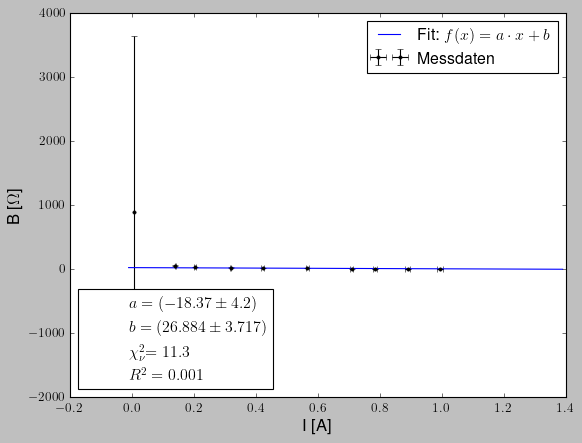

In [40]:
fig=plt.figure()
ax2=fig.add_subplot(111)
ax2.errorbar(n(x2),n(y2), xerr= s(x2), yerr= s(y2), fmt='.k',label='Messdaten')
ax2.plot(x_reg, y2_reg, label=r'Fit: $f(x) = a\cdot x +b$')

# Für die Parameter
par1, = ax2.plot([],[],' ')
par2, = ax2.plot([],[],' ' )
par3, = ax2.plot([],[],' ')
par4, = ax2.plot([],[],' ' )

leg1= ax2.legend(loc=1)
chi1=r'$\chi_{\nu}^{2}$'+f'$={chi_nu2}$'

ax2.set_xlabel('I [A]')
ax2.set_ylabel(r'B [$\Omega$]')
leg2=ax2.legend([par1,par2,par3,par4],
               [fr'$a=({round(a_x2,2)}\pm {round(da_x2,2)})$ ',
                fr'$b =({round(b_x2,3)}\pm {round(db_x2,3)})$',
               chi1,
               fr'$R^{2}={R_sqq2}$'],
              loc=3)
ax2.add_artist(leg1)
plt.show()

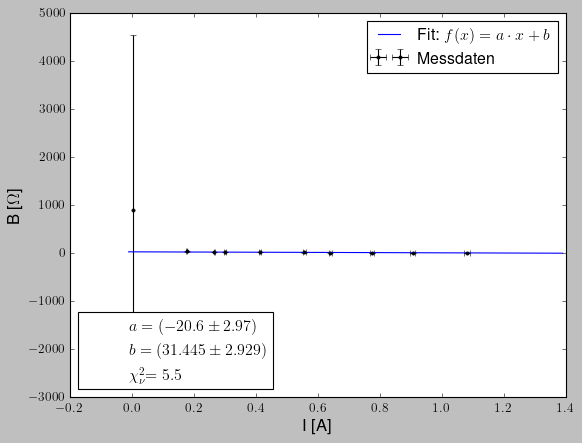

In [41]:
fig=plt.figure()

##############################################################################################
ax3=fig.add_subplot(111)
ax3.errorbar(n(x3),n(y3), xerr= s(x3), yerr= s(y3), fmt='.k',label='Messdaten')
ax3.plot(x_reg, y3_reg, label=r'Fit: $f(x) = a\cdot x +b$')

# Für die Parameter
par1, = ax3.plot([],[],' ')
par2, = ax3.plot([],[],' ' )
par3, = ax3.plot([],[],' ')
par4, = ax3.plot([],[],' ' )

leg1= ax3.legend(loc=1)
chi1=r'$\chi_{\nu}^{2}$'+f'$={chi_nu3}$'

ax3.set_xlabel('I [A]')
ax3.set_ylabel(r'B [$\Omega$]')
leg2=ax3.legend([par1,par2,par3,par4],
               [fr'$a=({round(a_x3,2)}\pm {round(da_x3,2)})$ ',
                fr'$b =({round(b_x3,3)}\pm {round(db_x3,3)})$',
               chi1],loc=3)
               # fr'$R^{2}={R_sqq}$'],

ax3.add_artist(leg1)
plt.show()


## Kacpers Vorgehensweise

### Daten laden

In [42]:
r3kv = pd.read_csv('r_3kV.txt', sep='\t')
print(r3kv.head())
r4kv = pd.read_csv('r_4kV.txt', sep='\t')
print(r4kv.head())
r5kv = pd.read_csv('r_5kV.txt', sep='\t')
print(r5kv.head())

       x       y      u_x      u_y
0  0.006  893.85  0.00001  1863.06
1  0.220   35.36  0.00010     2.27
2  0.411   20.07  0.00100     0.88
3  0.519   15.19  0.00100     0.56
4  0.620   13.21  0.00100     0.44
       x       y      u_x      u_y
0  0.007  893.85  0.00001  2750.70
1  0.140   59.23  0.00010     5.60
2  0.204   37.67  0.00010     2.53
3  0.319   28.10  0.00010     3.02
4  0.422   21.95  0.00100     2.02
       x       y      u_x      u_y
0  0.005  893.85  0.00001  3646.90
1  0.177   43.13  0.00010     9.23
2  0.267   33.27  0.00010     2.05
3  0.301   31.38  0.00010     1.86
4  0.414   24.12  0.00100     2.35


In [43]:
x3kv = r3kv['x']
y3kv = r3kv['y']
u_x3kv  = r3kv['u_x']
u_y3kv = r3kv['u_y']

x4kv = r4kv['x']
y4kv = r4kv['y']
u_x4kv  = r4kv['u_x']
u_y4kv = r4kv['u_y']

x5kv = r5kv['x']
y5kv = r5kv['y']
u_x5kv  = r5kv['u_x']
u_y5kv = r5kv['u_y']

### Visualisierung

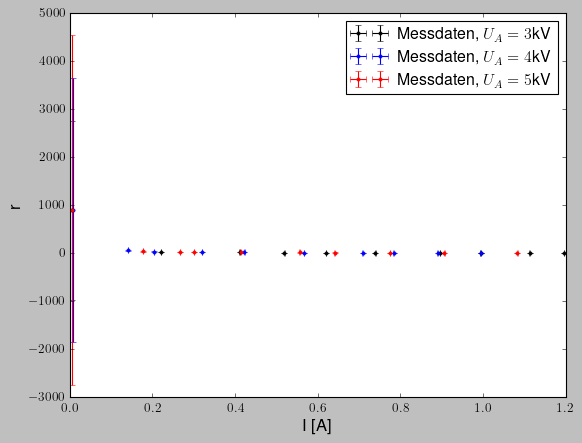

In [44]:
plt.errorbar(x3kv[ :], y3kv[ :], xerr = u_x3kv[ :], yerr = u_y3kv[ :],fmt='k.', label=r'Messdaten, $U_A = 3$kV')
plt.errorbar(x4kv[ :], y4kv[ :], xerr = u_x4kv[ :], yerr = u_y4kv[ :],fmt='b.', label=r'Messdaten, $U_A = 4$kV')
plt.errorbar(x5kv[ :], y5kv[ :], xerr = u_x5kv[ :], yerr = u_y5kv[ :],fmt='r.', label=r'Messdaten, $U_A = 5$kV')
plt.xlabel(r'I [A]')
plt.ylabel('r')
plt.legend()
plt.show()

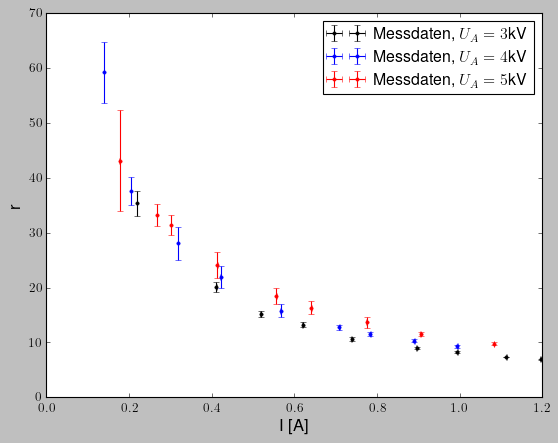

In [45]:
plt.errorbar(x3kv[1:], y3kv[1:], xerr = u_x3kv[1:], yerr = u_y3kv[1:],fmt='k.', label=r'Messdaten, $U_A = 3$kV')
plt.errorbar(x4kv[1:], y4kv[1:], xerr = u_x4kv[1:], yerr = u_y4kv[1:],fmt='b.', label=r'Messdaten, $U_A = 4$kV')
plt.errorbar(x5kv[1:], y5kv[1:], xerr = u_x5kv[1:], yerr = u_y5kv[1:],fmt='r.', label=r'Messdaten, $U_A = 5$kV')
plt.xlabel(r'I [A]')
plt.ylabel('r')
plt.legend()
plt.show()

### gewichtete Regression

In [46]:
pop, cov = curve_fit(reg1, x3kv, y3kv, sigma=u_y3kv)
a3kv, b3kv = pop
u_a3kv, u_b3kv = np.sqrt(np.diag(cov))

pop, cov = curve_fit(reg1, x4kv, y4kv, sigma=u_y4kv)
a4kv, b4kv = pop
u_a4kv, u_b4kv = np.sqrt(np.diag(cov))

pop, cov = curve_fit(reg1, x5kv, y5kv, sigma=u_y5kv)
a5kv, b5kv = pop
u_a5kv, u_b5kv = np.sqrt(np.diag(cov))

#### Plot

In [47]:
xx = np.arange(0, 1.3, 0.1)
yy1 = reg1(xx, a3kv, b3kv)
yy2 = reg1(xx, a4kv, b4kv)
yy3 = reg1(xx, a5kv, b5kv)

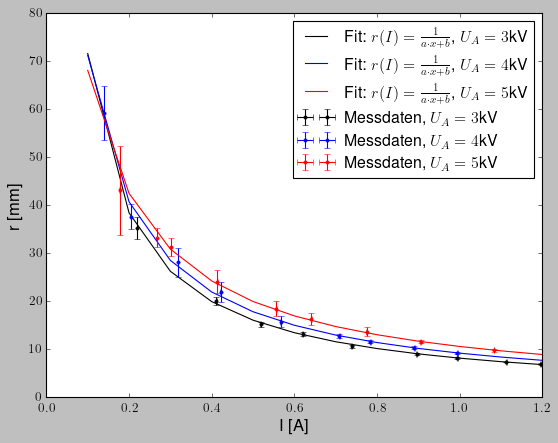

In [48]:
plt.errorbar(x3kv[1 :], y3kv[ 1:], xerr = u_x3kv[ 1:], yerr = u_y3kv[1 :],fmt='k.', label=r'Messdaten, $U_A = 3$kV')
plt.plot(xx[1:], yy1[1:],'k' ,label=r'Fit: $r(I) = \frac{1}{a \cdot x + b}$, $U_A = 3$kV')
plt.errorbar(x4kv[ 1:], y4kv[ 1:], xerr = u_x4kv[ 1:], yerr = u_y4kv[1 :],fmt='b.', label=r'Messdaten, $U_A = 4$kV')
plt.plot(xx[1:], yy2[1:], 'b' ,label=r'Fit: $r(I) = \frac{1}{a \cdot x + b}$, $U_A = 4$kV')
plt.errorbar(x5kv[ 1:], y5kv[ 1:], xerr = u_x5kv[ 1:], yerr = u_y5kv[ 1:],fmt='r.', label=r'Messdaten, $U_A = 5$kV')
plt.plot(xx[1:], yy3[1:],'r' , label=r'Fit: $r(I) = \frac{1}{a \cdot x + b}$, $U_A = 5$kV')
plt.xlabel(r'I [A]')
plt.ylabel('r [mm]')
plt.legend()
plt.show()

In [49]:
r1= chi_sq(x3kv[1:],y3kv[1:],  a3kv,b3kv, u_y3kv[1:])
print(r1)
r2= chi_sq(x4kv[1:],y4kv[1:],  a4kv,b4kv, u_y4kv[1:])
print(r2)
r3= chi_sq(x5kv[1:],y5kv[1:],  a3kv,b5kv, u_y5kv[1:])
print(r3)

(np.float64(17699.9), np.float64(2528.6), np.float64(0.543))
(np.float64(5353.4), np.float64(764.8), np.float64(0.293))
(np.float64(3587.1), np.float64(512.4), np.float64(0.542))


### Logarithmisieren

In [50]:
# x3kv = np.log(r3kv['x'])
# y3kv = np.log(r3kv['y'])
# u_x3kv  = r3kv['u_x']
# u_y3kv = np.log(r3kv['u_y'])

# x4kv = np.log(r4kv['x'])
# y4kv = np.log(r4kv['y'])
# u_x4kv  = r4kv['u_x']
# u_y4kv = np.log(r4kv['u_y'])

# x5kv = np.log(r5kv['x'])
# y5kv = np.log(r5kv['y'])
# u_x5kv  = r5kv['u_x']
# u_y5kv = np.log(r5kv['u_y'])

In [51]:
# pop, cov = curve_fit(reg, x3kv, y3kv, sigma=u_y3kv)
# a3kv, b3kv = pop
# u_a3kv, u_b3kv = np.sqrt(np.diag(cov))

# pop, cov = curve_fit(reg, x4kv, y4kv, sigma=u_y4kv)
# a4kv, b4kv = pop
# u_a4kv, u_b4kv = np.sqrt(np.diag(cov))

# pop, cov = curve_fit(reg, x5kv, y5kv, sigma=u_y5kv)
# a5kv, b5kv = pop
# u_a5kv, u_b5kv = np.sqrt(np.diag(cov))

In [52]:
# r1= chi_sq(x3kv[1:],y3kv[1:],  a3kv,b3kv, u_y3kv[1:])
# print(r1)
# r2= chi_sq(x4kv[1:],y4kv[1:],  a4kv,b4kv, u_y4kv[1:])
# print(r2)
# r3= chi_sq(x5kv[1:],y5kv[1:],  a3kv,b5kv, u_y5kv[1:])
# print(r3)

In [53]:
# xx = np.arange(-2, 1.3, 0.1)
# yy1 = reg(xx, a3kv, b3kv)
# yy2 = reg(xx, a4kv, b4kv)
# yy3 = reg(xx, a5kv, b5kv)

In [54]:
# plt.errorbar(x3kv[1 :], y3kv[ 1:], xerr = u_x3kv[ 1:], yerr = u_y3kv[1 :],fmt='k.', label=r'Messdaten, $U_A = 3$kV')
# plt.plot(xx[1:], yy1[1:],'k' ,label=r'Fit: $r(I) = \log{ \frac{1}{a \cdot I + b}}$, $U_A = 3$kV')
# plt.errorbar(x4kv[ 1:], y4kv[ 1:], xerr = u_x4kv[ 1:], yerr = u_y4kv[1 :],fmt='b.', label=r'Messdaten, $U_A = 4$kV')
# plt.plot(xx[1:], yy2[1:], 'b' ,label=r'Fit: $r(I) =\log{ \frac{1}{a \cdot I + b}}$, $U_A = 4$kV')
# plt.errorbar(x5kv[ 1:], y5kv[ 1:], xerr = u_x5kv[ 1:], yerr = u_y5kv[ 1:],fmt='r.', label=r'Messdaten, $U_A = 5$kV')
# plt.plot(xx[1:], yy3[1:],'r' , label=r'Fit: $r(I) = \log{ \frac{1}{a \cdot I + b}}$, $U_A = 5$kV')
# plt.xlabel(r'I [A]')
# plt.ylabel('r [mm]')
# plt.legend()
# plt.show()

### zweite Versuch

In [55]:
x3kv = r3kv['x']
y3kv = r3kv['y']
u_x3kv  = r3kv['u_x']
u_y3kv = r3kv['u_y']

x4kv = r4kv['x']
y4kv = r4kv['y']
u_x4kv  = r4kv['u_x']
u_y4kv = r4kv['u_y']

x5kv = r5kv['x']
y5kv = r5kv['y']
u_x5kv  = r5kv['u_x']
u_y5kv = r5kv['u_y']

In [56]:
pop, cov = curve_fit(reg2, x3kv, y3kv, sigma=u_y3kv)
a3kv, b3kv = pop
u_a3kv, u_b3kv = np.sqrt(np.diag(cov))

pop, cov = curve_fit(reg2, x4kv, y4kv, sigma=u_y4kv)
a4kv, b4kv = pop
u_a4kv, u_b4kv = np.sqrt(np.diag(cov))

pop, cov = curve_fit(reg2, x5kv, y5kv, sigma=u_y5kv)
a5kv, b5kv = pop
u_a5kv, u_b5kv = np.sqrt(np.diag(cov))

In [57]:
r1= chi_sq(x3kv,y3kv,  a3kv,b3kv, u_y3kv)
print(r1)
r2= chi_sq(x4kv,y4kv,  a4kv,b4kv, u_y4kv)
print(r2)
r3= chi_sq(x5kv,y5kv,  a5kv,b5kv, u_y5kv)
print(r3)

(np.float64(2424.0), np.float64(303.0), np.float64(0.0))
(np.float64(854.0), np.float64(106.8), np.float64(0.0))
(np.float64(695.5), np.float64(86.9), np.float64(0.0))


In [58]:
xx = np.arange(0.1, 1.3, 0.01)
yy1 = reg2(xx, a3kv, b3kv)
yy2 = reg2(xx, a4kv, b4kv)
yy3 = reg2(xx, a5kv, b5kv)
nu = r'\nu'

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\2390516302.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a = ({round(a3kv,2)}\pm{round(u_a3kv,2)})$ cm $\cdot$ A')
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\2390516302.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a = ({round(a3kv,2)}\pm{round(u_a3kv,2)})$ cm $\cdot$ A')
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\2390516302.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar([],[],fmt='w.',yerr =[],label=f'$b = (

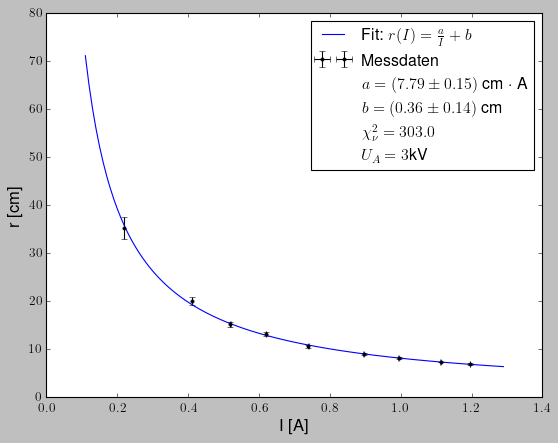

In [59]:
plt.errorbar(x3kv[1 :], y3kv[ 1:], xerr = u_x3kv[ 1:], yerr = u_y3kv[1 :],fmt='k.', label=r'Messdaten')
plt.plot(xx[1:], yy1[1:],'b' ,label=r'Fit: $r(I) = \frac{a}{I}+b$')
plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a = ({round(a3kv,2)}\pm{round(u_a3kv,2)})$ cm $\cdot$ A')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$b = ({round(b3kv,2)}\pm{round(u_b3kv,2)})$ cm')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$\chi_{nu}^{2}={round(r1[1],1)}$')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$U_A = 3$kV')
plt.xlabel(r'I [A]')
plt.ylabel('r [cm]')
plt.legend()
# plt.show()
# plt.savefig('r(I)-U3kV.pdf',dpi=600)
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\3292060058.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a = ({round(a4kv,2)}\pm{round(u_a4kv,2)})$ cm $\cdot$ A')
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\3292060058.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a = ({round(a4kv,2)}\pm{round(u_a4kv,2)})$ cm $\cdot$ A')
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\3292060058.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar([],[],fmt='w.',yerr =[],label=f'$b = (

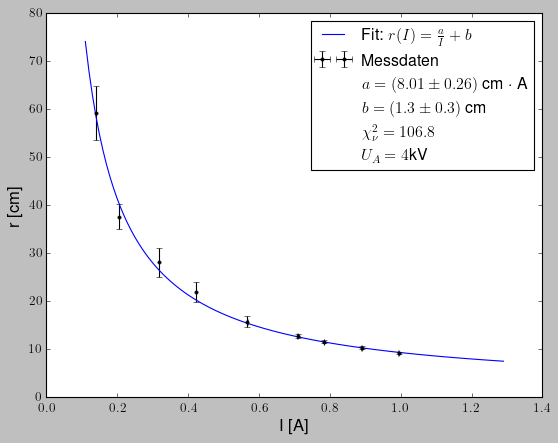

In [60]:
plt.errorbar(x4kv[ 1:], y4kv[ 1:], xerr = u_x4kv[ 1:], yerr = u_y4kv[1 :],fmt='k.', label=r'Messdaten')
plt.plot(xx[1:], yy2[1:], 'b' ,label=r'Fit: $r(I) = \frac{a}{I}+b$')
plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a = ({round(a4kv,2)}\pm{round(u_a4kv,2)})$ cm $\cdot$ A')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$b = ({round(b4kv,1)}\pm{round(u_b4kv,1)})$ cm')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$\chi_{nu}^{2}={round(r2[1],1)}$')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$U_A = 4$kV')
plt.xlabel(r'I [A]')
plt.ylabel('r [cm]')
plt.legend()
plt.show()
# plt.savefig('r(I)-U4kV.pdf',dpi=600)

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\927151759.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a= ({round(a5kv,2)}\pm{round(u_a5kv,2)})$ cm $\cdot$ A')
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\927151759.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a= ({round(a5kv,2)}\pm{round(u_a5kv,2)})$ cm $\cdot$ A')
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\927151759.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar([],[],fmt='w.',yerr =[],label=f'$b= ({round

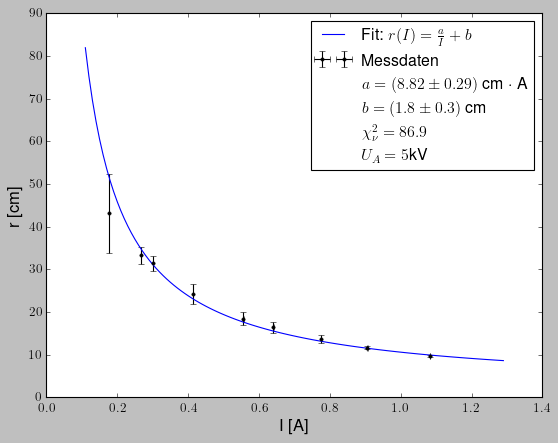

In [61]:
plt.errorbar(x5kv[ 1:], y5kv[ 1:], xerr = u_x5kv[ 1:], yerr = u_y5kv[ 1:],fmt='k.', label=r'Messdaten')
plt.plot(xx[1:], yy3[1:],'b' , label=r'Fit: $r(I) = \frac{a}{I}+b$')
plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a= ({round(a5kv,2)}\pm{round(u_a5kv,2)})$ cm $\cdot$ A')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$b= ({round(b5kv,1)}\pm{round(u_b5kv,1)})$ cm')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$\chi_{nu}^{2}={round(r3[1],1)}$')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$U_A = 5$kV')
plt.xlabel(r'I [A]')
plt.ylabel('r [cm]')
plt.legend()
plt.show()
# plt.savefig('r(I)-U5kV.pdf',dpi=600)

## e/m 
mit den Ergebnissen aus dem zweiten Versuch

### Fehlerrechnung und Berechnung
$$ \frac{e}{m}= 2 U_A \cdot \frac{1}{a^2 \cdot k^2} \\\partial_{U_A} e/m = \frac{2}{a^2 k^2}\\
\partial_k e/m = - \frac{4 U_A}{a^2 k^3}\\
\partial_a e/m = - \frac{4 U_A}{a^3 k^2}$$

$$ u_{e/m}= \frac{2}{a^2 k^2} \sqrt{u_{U_A}^2 +  4 U_A^2 \frac{u_k^2}{k^2}+  4 U_A^2 \frac{u_a^2}{a^2}}$$

In [62]:
u_UA_3kv = 3e3 * 0.025
u_UA_4kv = 4e3 * 0.025
u_UA_5kv = 5e3 * 0.025

aa1 = a3kv/100
u_aa1 = u_a3kv/100
aa2 = a4kv/100
u_aa2 = u_a4kv/100
aa3 = a5kv/100
u_aa3 = u_a5kv/100

In [63]:
em_r_U3,u_em_3kv = u_e_m_r(3e3, k_n ,aa1 , u_UA_3kv, u_k_n , u_aa1)
print(u_em_3kv/em_r_U3)
em_r_U4,u_em_4kv = u_e_m_r(4e3,k_n ,aa2 , u_UA_4kv, u_k_n , u_aa2)
print(u_em_4kv/em_r_U4)
em_r_U5,u_em_5kv = u_e_m_r(5e3, k_n ,aa3 , u_UA_5kv, u_k_n , u_aa2)
print(u_em_5kv/em_r_U5)

[4.68061805e+10 4.68061805e+10 4.68061805e+10 4.68061805e+10
 4.68061805e+10 4.68061805e+10 4.68061805e+10 4.68061805e+10
 4.68061805e+10 4.68061805e+10 6.24082407e+10 6.24082407e+10
 6.24082407e+10 6.24082407e+10 6.24082407e+10 6.24082407e+10
 6.24082407e+10 6.24082407e+10 6.24082407e+10 6.24082407e+10
 7.80103009e+10 7.80103009e+10 7.80103009e+10 7.80103009e+10
 7.80103009e+10 7.80103009e+10 7.80103009e+10 7.80103009e+10
 7.80103009e+10 7.80103009e+10]
[8.28632160e+10 8.28632160e+10 8.28632160e+10 8.28632160e+10
 8.28632160e+10 8.28632160e+10 8.28632160e+10 8.28632160e+10
 8.28632160e+10 8.28632160e+10 1.10484288e+11 1.10484288e+11
 1.10484288e+11 1.10484288e+11 1.10484288e+11 1.10484288e+11
 1.10484288e+11 1.10484288e+11 1.10484288e+11 1.10484288e+11
 1.38105360e+11 1.38105360e+11 1.38105360e+11 1.38105360e+11
 1.38105360e+11 1.38105360e+11 1.38105360e+11 1.38105360e+11
 1.38105360e+11 1.38105360e+11]
[6.52019665e+10 6.52019665e+10 6.52019665e+10 6.52019665e+10
 6.52019665e+10 6.520

In [64]:
true_em = 1.76e11
print(em_r_U3/true_em)
print(em_r_U4/true_em)
print(em_r_U5/true_em)

[9.99450168e-13 9.99450168e-13 9.99450168e-13 9.99450168e-13
 9.99450168e-13 9.99450168e-13 9.99450168e-13 9.99450168e-13
 9.99450168e-13 9.99450168e-13 7.49587626e-13 7.49587626e-13
 7.49587626e-13 7.49587626e-13 7.49587626e-13 7.49587626e-13
 7.49587626e-13 7.49587626e-13 7.49587626e-13 7.49587626e-13
 5.99670101e-13 5.99670101e-13 5.99670101e-13 5.99670101e-13
 5.99670101e-13 5.99670101e-13 5.99670101e-13 5.99670101e-13
 5.99670101e-13 5.99670101e-13]
[1.05655782e-12 1.05655782e-12 1.05655782e-12 1.05655782e-12
 1.05655782e-12 1.05655782e-12 1.05655782e-12 1.05655782e-12
 1.05655782e-12 1.05655782e-12 7.92418363e-13 7.92418363e-13
 7.92418363e-13 7.92418363e-13 7.92418363e-13 7.92418363e-13
 7.92418363e-13 7.92418363e-13 7.92418363e-13 7.92418363e-13
 6.33934690e-13 6.33934690e-13 6.33934690e-13 6.33934690e-13
 6.33934690e-13 6.33934690e-13 6.33934690e-13 6.33934690e-13
 6.33934690e-13 6.33934690e-13]
[1.28096953e-12 1.28096953e-12 1.28096953e-12 1.28096953e-12
 1.28096953e-12 1.280

### relativer Fehler

In [65]:
em_3kv = 2* 3e3/(k_n*a3kv/100)**2
em_4kv = 2* 4e3 /(k_n*a4kv/100)**2
em_5kv = 2* 5e3 /(k_n*a5kv/100)**2

print('relativer Fehler:')
print(f'für 3kv: {round(u_em_3kv/em_3kv*100,2)}%')
print(f'für 4kv: {round(u_em_4kv/em_4kv*100,2)}%')
print(f'für 5kv: {round(u_em_5kv/em_5kv*100,2)}%')

relativer Fehler:
für 3kv: 4.79%
für 4kv: 7.1%
für 5kv: 6.57%


In [66]:
print( em_3kv)

print( em_4kv)
print( em_5kv)

171978581822.83752
216910700996.03348
223637927097.6636


### Plot

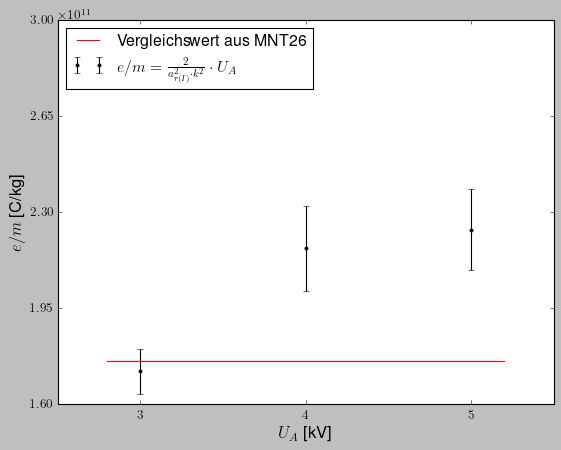

In [67]:
x_em = np.array([3, 4 ,5])
y_em = np.array([em_3kv,em_4kv,em_5kv])

xx_em = np.arange(2.8,5.21,0.2)
yy_em_unb15 = np.ones(13) * 1.758820088e11
yy_em_unb15_unt = np.ones(13) * 1.758820088e11-0.000000088e11
yy_em_unb15_ob = np.ones(13) * 1.758820088e11+0.000000088e11

yy_em_MNT16 = np.ones(13) * 1.758820024e11
yy_em_MNT16_unt = np.ones(13) * 1.758820024e11-0.000000011e11
yy_em_MNT16_ob = np.ones(13) * 1.758820024e11+0.000000011e11


plt.errorbar(x_em, y_em, fmt='k.',yerr = [u_em_3kv,u_em_4kv,u_em_5kv],label=r'$e/m = \frac{2}{a_{r(I)}^2\cdot k^2}\cdot U_A $')


plt.plot(xx_em, yy_em_MNT16, 'r-', label='Vergleichswert aus MNT26')

plt.xticks([3,4,5])
plt.yticks(np.arange(1.6e11,3.1e11,0.35e11))
plt.legend(loc=2)
plt.xlabel(r'$U_A$ [kV]')
plt.ylabel(r'$e/m$ [C/kg]')
plt.show()
# plt.savefig('em_r.pdf',dpi=600)

# Aufgabe 7
Für drei fest eingestellte Anodenspannungen $U_A$ von 3 kV, 4 kV und 5 kV ist jeweils die Kompensationsmethode
einzusetzen und dafür die Abhängigkeit (9) in der abgewandelten Form
 $U_k(I) ~ I$ für mehrere Messwertpaare aufzunehmen, jeweils im Diagramm darzustellen und über
eine geeignete Modellfunktion die spezifische Elektronenladung mit ihrer Unsicherheit zu bestimmen.
(Beobachten Sie beim Experimentieren die Bahn des Elektronenstrahls auf dem
Leuchtschirm und dokumentieren Sie ggf. überraschende Feststellungen! Zur Bestimmung des
Plattenabstands , und seiner Unsicherheit $d$ ist es ohnehin sinnvoll, ein eigenes Foto aufzunehmen.)
Die so gewonnenen Ergebnisse sind auf ihre innere Konsistenz zu prüfen und erneut
mit dem Referenzwert der spezifischen Ladung zu vergleichen.

## Meine Vorgehensweise

In [68]:
A7.head()

,I,U_k
0,0.097,60.89
1,0.147,83.88
2,0.293,133.08
3,0.450,232.80
4,0.490,242.33


### Fehlerrechnung

In [69]:
# Spannung
u_err = np.array(A7['U_k'])*0.005  # siehe Conrad/ VC 650
U_k = np.array(A7['U_k'])
U_kerr = unp.uarray(U_k, u_err)

# Strom 0.9%
i_err = np.array(A7['I'])*0.009
I7 = np.array(A7['I'])
I7_err = unp.uarray(I7,i_err)

In [70]:
uu_y3kv=u_err[:10]
print(uu_y3kv)
uu_y4kv = u_err[10:20]
print(uu_y4kv)
uu_y5kv = u_err[20:30]
print(uu_y5kv)

[0.30445 0.4194  0.6654  1.164   1.21165 1.32165 1.58665 1.65205 1.82125
 2.21   ]
[0.3875  0.5975  0.9095  1.09355 1.26475 1.46625 1.931   2.0875  2.502
 2.5245 ]
[0.47475 0.69425 1.103   1.28575 1.4296  1.6672  2.1435  2.3055  2.548
 2.4305 ]


### Visualisierung

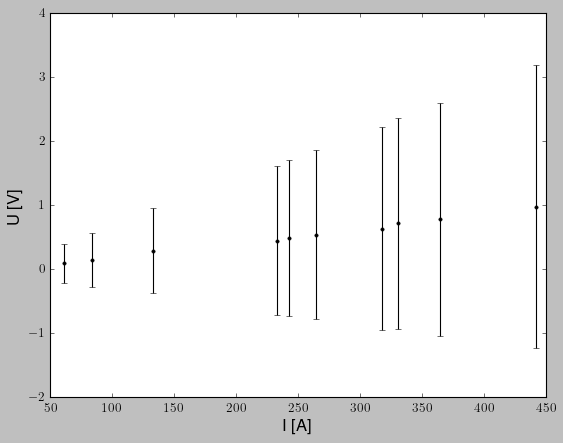

In [71]:
plt.errorbar(U_k[:10], I7[:10],fmt='k.', yerr=u_err[:10])
plt.xlabel('I [A]')
plt.ylabel('U [V]')
plt.show()

## Kacpers Vorgehensweise

In [72]:
U3kv = pd.read_csv('U_3kV.txt', sep='\t')
print(U3kv.head())
U4kv = pd.read_csv('U_4kV.txt', sep='\t')
print(U4kv.head())
U5kv = pd.read_csv('U_5kV.txt', sep='\t')
print(U5kv.head())

       x       y     u_x   u_y
0  0.097   60.89  0.0001  0.03
1  0.147   83.88  0.0001  0.04
2  0.293  153.08  0.0001  0.08
3  0.450  232.80  0.0010  0.12
4  0.490  242.80  0.0010  0.12
       x       y     u_x   u_y
0  0.088   77.50  0.0001  0.04
1  0.147  115.04  0.0001  0.06
2  0.262  181.90  0.0001  0.09
3  0.335  218.71  0.0001  0.11
4  0.404  252.95  0.0010  0.13
       x       y     u_x   u_y
0  0.071   94.95  0.0001  0.05
1  0.161  158.85  0.0001  0.08
2  0.261  220.60  0.0001  0.11
3  0.313  257.15  0.0001  0.13
4  0.410  285.92  0.0010  0.14


In [73]:
x3kv1 = U3kv['x']
y3kv1 = U3kv['y']
u_x3kv1  = U3kv['u_x']
u_y3kv1 = U3kv['u_y']

x4kv1 = U4kv['x']
y4kv1 = U4kv['y']
u_x4kv1  = U4kv['u_x']
u_y4kv1 = U4kv['u_y']

x5kv1 = U5kv['x']
y5kv1 = U5kv['y']
u_x5kv1  = U5kv['u_x']
u_y5kv1 = U5kv['u_y']

### Visualisierung

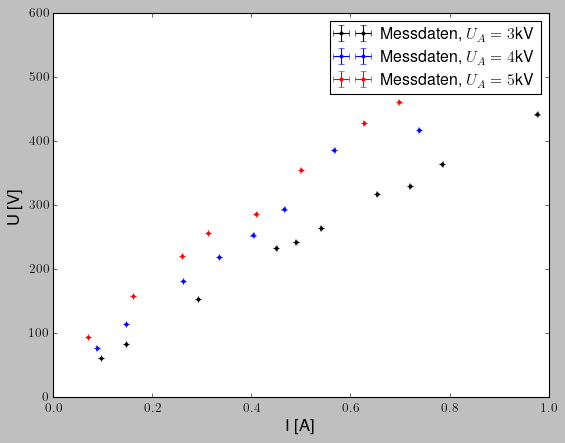

In [74]:
plt.errorbar(x3kv1[ :], y3kv1[ :], xerr = u_x3kv1[ :], yerr = u_y3kv1[ :],fmt='k.', label=r'Messdaten, $U_A = 3$kV')
plt.errorbar(x4kv1[ :], y4kv1[ :], xerr = u_x4kv1[ :], yerr = u_y4kv1[ :],fmt='b.', label=r'Messdaten, $U_A = 4$kV')
plt.errorbar(x5kv1[ :], y5kv1[ :], xerr = u_x5kv1[ :], yerr = u_y5kv1[ :],fmt='r.', label=r'Messdaten, $U_A = 5$kV')
plt.xlabel(r'I [A]')
plt.ylabel('U [V]')
plt.legend()
plt.show()

In [75]:
# plt.errorbar(x3kv1, y3kv1, xerr = u_x3kv1, yerr = u_y3kv,fmt='k.', label=r'Messdaten, $U_A = 3$kV')
# plt.errorbar(x4kv1, y4kv1, xerr = u_x4kv1, yerr = uu_y4kv,fmt='b.', label=r'Messdaten, $U_A = 4$kV')
# plt.errorbar(x5kv1, y5kv1, xerr = u_x5kv1, yerr = uu_y5kv,fmt='r.', label=r'Messdaten, $U_A = 5$kV')
# plt.xlabel(r'I [A]')
# plt.ylabel('U [A]')
# plt.legend()
# plt.show()

### Regression

In [76]:
pop, cov = curve_fit(reg, x3kv1, y3kv1, sigma=u_y3kv1)
a3kv1, b3kv1 = pop
da3kv1, db3kv1 = np.sqrt(np.diag(cov))

pop, cov = curve_fit(reg, x4kv1, y4kv1, sigma=u_y4kv1)
a4kv1, b4kv1 = pop
da4kv1, db4kv1 = np.sqrt(np.diag(cov))

pop, cov = curve_fit(reg, x5kv1, y5kv1, sigma=u_y5kv1)
a5kv1, b5kv1 = pop
da5kv1, db5kv1 = np.sqrt(np.diag(cov))

#### Regression mit Statsmodels

In [77]:
y=y3kv1
x_zunahme=sm.add_constant(x3kv1)
results=sm.WLS(y,x_zunahme,sigma=u_y3kv1).fit()#,sigma=yerr
print('''
Lineare Regression
''')
print(results.summary())


Lineare Regression

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2391.
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           3.38e-11
Time:                        16:56:58   Log-Likelihood:                -33.196
No. Observations:                  10   AIC:                             70.39
Df Residuals:                       8   BIC:                             71.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9088      5.14

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['sigma']
  warnings.warn(msg, ValueWarning)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [78]:
y=y4kv1
x_zunahme=sm.add_constant(x4kv1)
results=sm.WLS(y,x_zunahme,sigma=u_y4kv1).fit()#,sigma=yerr
print('''
Lineare Regression
''')
print(results.summary())


Lineare Regression

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            WLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     386.6
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           4.66e-08
Time:                        16:56:58   Log-Likelihood:                -44.451
No. Observations:                  10   AIC:                             92.90
Df Residuals:                       8   BIC:                             93.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.7742     14.30

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['sigma']
  warnings.warn(msg, ValueWarning)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [79]:
y=y5kv1
x_zunahme=sm.add_constant(x5kv1)
results=sm.WLS(y,x_zunahme,sigma=u_y5kv1).fit()#,sigma=yerr
print('''
Lineare Regression
''')
print(results.summary())


Lineare Regression

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2007.
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           6.80e-11
Time:                        16:56:58   Log-Likelihood:                -35.746
No. Observations:                  10   AIC:                             75.49
Df Residuals:                       8   BIC:                             76.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.6136      6.52

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['sigma']
  warnings.warn(msg, ValueWarning)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


#### chi^2

In [80]:
U1= chi_sq(x3kv1,y3kv1,  a3kv1,b3kv1, u_y3kv1)
print(U1)
U2= chi_sq(x4kv1,y4kv1,  a4kv1,b4kv1, u_y4kv1)
print(U2)
U3= chi_sq(x5kv1,y5kv1,  a5kv1,b5kv1, u_y5kv1)
print(U3)

(np.float64(26480.2), np.float64(3310.0), np.float64(1.033))
(np.float64(138485.1), np.float64(17310.6), np.float64(1.076))
(np.float64(54599.9), np.float64(6825.0), np.float64(1.043))


### Plot

In [81]:
xA7 = np.arange(0,1.1,0.1)
y1A7 = reg(xA7, a3kv1,b3kv1)
y2A7 = reg(xA7, a4kv1,b4kv1)
y3A7 = reg(xA7, a5kv1,b5kv1)

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\2544461242.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a= {round(a5kv1,2)}\pm{round(da5kv1,2)}$')
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\2544461242.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar([],[],fmt='w.',yerr =[],label=f'$b= {round(b5kv1,1)}\pm{round(db5kv1,1)}$')
C:\Users\benjf\AppData\Local\Temp\ipykernel_15100\2544461242.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.errorbar([],[],fmt='w.',yerr =[],label=f'$\chi_{nu}^{2}={round(U1[1],1)}$')


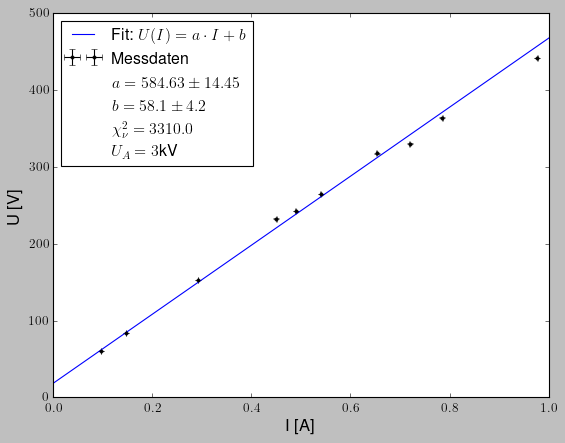

In [82]:
plt.errorbar(x3kv1[ :], y3kv1[ :], xerr = u_x3kv1[ :], yerr = u_y3kv1[ :],fmt='k.', label=r'Messdaten')
plt.plot(xA7, y1A7, 'b', label=r'Fit: $U(I) = a \cdot I + b$')
plt.errorbar([],[],fmt='w.', yerr =[],label=f'$a= {round(a5kv1,2)}\pm{round(da5kv1,2)}$')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$b= {round(b5kv1,1)}\pm{round(db5kv1,1)}$')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$\chi_{nu}^{2}={round(U1[1],1)}$')
plt.errorbar([],[],fmt='w.',yerr =[],label=f'$U_A = 3$kV')
plt.xlabel(r'I [A]')
plt.ylabel('U [V]')
plt.legend(loc=2)
plt.show()

In [83]:
A = 'A'
V = 'V'

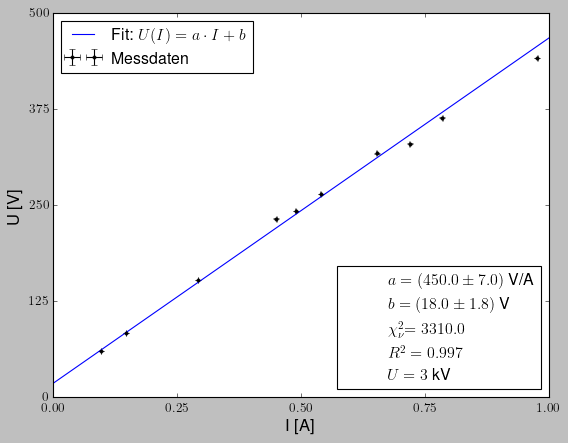

In [84]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(x3kv1[ :], y3kv1[ :], xerr = u_x3kv1[ :], yerr = u_y3kv1[ :],fmt='k.', label=r'Messdaten')
ax.plot(xA7, y1A7, 'b', label=r'Fit: $U(I) = a \cdot I + b$')

# Für die Parameter
par1, = ax.plot([],[],' ')
par2, = ax.plot([],[],' ' )
par3, = ax.plot([],[],' ')
par4, = ax.plot([],[],' ' )
par5, = ax.plot([],[],' ' )

leg1= ax.legend(loc=2)
chi1=r'$\chi_{\nu}^{2}$'+f'$={U1[1]}$'

ax.set_xlabel('I [A]')
ax.set_ylabel(r'U [V]')
leg2=ax.legend([par1,par2,par3,par4,par5],
               [fr'$a=({round(a3kv1,0)}\pm {round(da3kv1,0)})$ V/A ',
                fr'$b =({round(b3kv1,1)}\pm {round(db3kv1,1)})$ V',
               chi1,
               fr'$R^{2}=0.997$',
               '$U = 3$ kV'],
              loc=4)
ax.add_artist(leg1)
plt.xticks(np.arange(0,1.1, 0.25))
plt.yticks(np.arange(0, 501, 125))
plt.show()
# plt.savefig('U(I)-3kV.pdf',dpi=600)

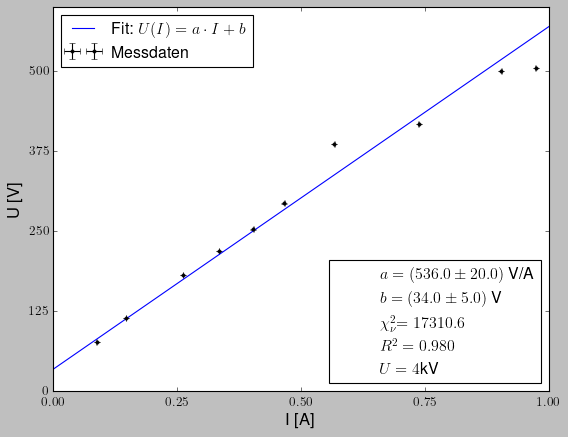

In [85]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(x4kv1[ :], y4kv1[ :], xerr = u_x4kv1[ :], yerr = u_y4kv1[ :],fmt='k.', label=r'Messdaten')
ax.plot(xA7, y2A7, 'b', label=r'Fit: $U(I) = a \cdot I + b$')

# Für die Parameter
par1, = ax.plot([],[],' ')
par2, = ax.plot([],[],' ' )
par3, = ax.plot([],[],' ')
par4, = ax.plot([],[],' ' )
par5, = ax.plot([],[],' ' )

leg1= ax.legend(loc=2)
chi1=r'$\chi_{\nu}^{2}$'+f'$={U2[1]}$'

ax.set_xlabel('I [A]')
ax.set_ylabel(r'U [V]')
leg2=ax.legend([par1,par2,par3,par4,par5],
               [fr'$a=({round(a4kv1,0)}\pm {round(da4kv1,0)})$ V/A',
                fr'$b =({round(b4kv1,0)}\pm {round(db4kv1,0)})$ V',
               chi1,
               fr'$R^{2}=0.980$',
               r'$U = 4$kV'],
              loc=4)
ax.add_artist(leg1)
plt.xticks(np.arange(0,1.1, 0.25))
plt.yticks(np.arange(0, 501, 125))
plt.show()
# plt.savefig('U(I)-4kV.pdf',dpi=600)

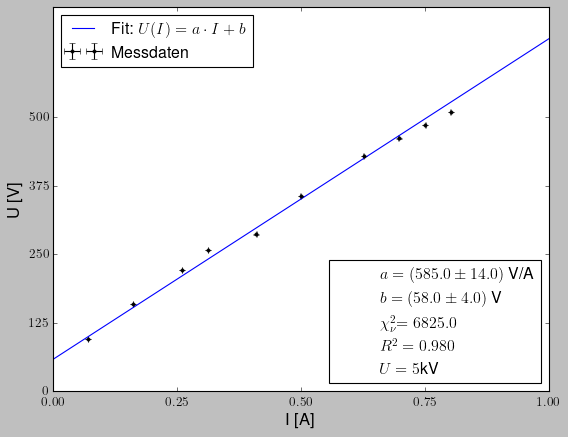

In [86]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(x5kv1[ :], y5kv1[ :], xerr = u_x5kv1[ :], yerr = u_y5kv1[ :],fmt='k.', label=r'Messdaten')
ax.plot(xA7, y3A7, 'b', label=r'Fit: $U(I) = a \cdot I + b$')

# Für die Parameter
par1, = ax.plot([],[],' ')
par2, = ax.plot([],[],' ' )
par3, = ax.plot([],[],' ')
par4, = ax.plot([],[],' ' )
par5, = ax.plot([],[],' ' )

leg1= ax.legend(loc=2)
chi1=r'$\chi_{\nu}^{2}$'+f'$={U3[1]}$'

ax.set_xlabel('I [A]')
ax.set_ylabel(r'U [V]')
leg2=ax.legend([par1,par2,par3,par4,par5],
               [fr'$a=({round(a5kv1,0)}\pm {round(da5kv1,0)})$ V/A',
                fr'$b =({round(b5kv1,0)}\pm {round(db5kv1,0)})$ V',
               chi1,
               fr'$R^{2}=0.980$',
               r'$U = 5$kV'],
              loc=4)
ax.add_artist(leg1)
plt.xticks(np.arange(0,1.1, 0.25))
plt.yticks(np.arange(0, 501, 125))
plt.show()
# plt.savefig('U(I)-5kV.pdf',dpi=600)

## e/m

$$ 
U_k (B) = \sqrt{2 \frac{e}{m} U_A} d \cdot B \\ 
U_k (I) = \sqrt{2 \frac{e}{m} U_A} \cdot d \cdot k \cdot I\\
\Rightarrow a_{U_k} =\sqrt{2 \frac{e}{m} U_A} \cdot d \cdot k\\
\Leftrightarrow a_{U_k}^2 = 2 \frac{e}{m} U_A \cdot d^2 \cdot k^2\\
\Rightarrow \frac{e}{m} = \frac{a_{U_k}^2}{2 U_A \cdot d^2 \cdot k^2}
$$

partielle Ableitungen von em 

$$ \partial_k em = 4 U_A \frac{d^2\cdot k}{a_{U_k}^2} = \frac{2d^2}{a_{U_k}^2} 2U_A \cdot k\\
\partial_{U_A} em = 2 \frac{d^2\cdot k^2}{a_{U_k}^2}\\
\partial_{U_A} em = - 4 U_A \frac{d^2\cdot k^2}{a_{U_k}^3}$$

$$ u_em = \frac{2 d^2}{a^2_{U_A}} \cdot \sqrt{4 U_A^2 k^2 u_k^2 + k^4 \cdot u_{U_A}^2 + 4 U_A^2 k^4 \frac{u_a^2}{a_{U_A}^6}}$$

In [87]:
em_U1, u_em_U1 =  u_em_Uk(3e3, k, a3kv1, 8/1000, 3e3*0.025, u_k, da3kv1)
em_U2, u_em_U2 =  u_em_Uk(4e3, k, a4kv1, 8/1000, 4e3*0.025, u_k, da4kv1)
em_U3, u_em_U3 =  u_em_Uk(5e3, k, a5kv1, 8/1000, 5e3*0.025, u_k, da5kv1)
print(em_U1/1e11)
print(u_em_U1/1e11)
print(em_U2/1e11)
print(u_em_U2/1e11)
print(em_U3/1e11)
print(u_em_U3/1e11)

1.1772513898287424
0.061651042793419104
1.2522839021741312
0.07791016887014901
1.1930912434412884
0.06654615472274525


### relativer Fehler

In [88]:
print('e/m für U3kV')
print(round(u_em_U1/em_U1*100,2),'%')
print('e/m für U4kV')
print(round(u_em_U2/em_U2*100,2),'%')
print('e/m für U5kV')
print(round(u_em_U3/em_U3*100,2),'%')

e/m für U3kV
5.24 %
e/m für U4kV
6.22 %
e/m für U5kV
5.58 %


### Plot

In [89]:
x_em1 = np.array([3, 4 ,5])
y_em1 = np.array([em_U1,em_U2,em_U3])

xx_em1 = np.arange(2.8,5.21,0.2)

yy_em_MNT161 = np.ones(13) * 1.758820024e11
# yy_em_MNT16_unt = np.ones(13) * 1.758820024e11-0.000000011e11
# yy_em_MNT16_ob = np.ones(13) * 1.758820024e11+0.000000011e11


plt.errorbar(x_em1, y_em1, fmt='k.',yerr = [u_em_U1,u_em_U2,u_em_U3],label=r'$e/m = \frac{a_{U(I)}^2}{2\cdot k^2\cdot d^2 \cdot U_A}  $')


plt.plot(xx_em1, yy_em_MNT161, 'r-', label='Vergleichswert aus MNT26')

plt.xticks([3,4,5])
plt.yticks(np.arange(0.8e11,1.81e11,0.25e11))
plt.legend(loc=7)
plt.xlabel(r'$U_A$ [kV]')
# plt.ylabel(r'$e/m$ [C/kg]')
# plt.savefig('em_Uk.pdf',dpi=600)

Text(0.5, 0, '$U_A$ [kV]')

# Aufgabe 8
Aus den Ergebnissen von Aufgabe 7 ist für alle verwendeten Anodenspannungen  $U_A$ jeweils die
Geschwindigkeit $v$ der Elektronen mit ihrer Unsicherheit abzuschätzen und dazu auch die Größe
der sog. relativistischen Korrektur. Ist sie relevant?

Nach dem Energieerhaltungssatz (8) können wir die Geschwindigkeit wie folgt abschätzen
$$ v = \sqrt{2 \frac{e}{m}U_A} $$

In [90]:
v1 = np.sqrt(2*3e3 * em_U1)
print(v1)
v2 = np.sqrt(2*4e3 * em_U2)
print(v2)
v3 = np.sqrt(2*5e3 * em_U3)
print(v3)
v_real1 = np.sqrt(2*3e3 * 1.758820024e11)
v_real2 = np.sqrt(2*4e3 * 1.758820024e11)
v_real3 = np.sqrt(2*5e3 * 1.758820024e11)

26577261.595153954
31651652.74893722
34541152.896816984


In [91]:
u_v1 = np.sqrt(2*em_U1*(0.025*3e3)**2+ 2*3e3*0.06**2)
print(u_v1)
u_v2 = np.sqrt(2) * np.sqrt(em_U2*(0.025*4e3)**2+ 4e3*0.08**2)
print(u_v2)
u_v3 = np.sqrt(2) * np.sqrt(em_U1*(0.025*5e3)**2+ 5e3*0.07**2)
print(u_v3)

36392414.230954185
50045657.19768613
60654023.71825689


In [92]:
print(ufloat(v1,u_v1))
print(ufloat(v2,u_v2))
print(ufloat(v3,u_v3))

(3+/-4)e+07
(3+/-5)e+07
(3+/-6)e+07


In [93]:
av1 = ufloat(v1,u_v1)
av2 = ufloat(v2,u_v2)
av3 = ufloat(v3,u_v3)
x1 = 1/(1-av1**2/(299792458)**2)
print(x1)
x2 = 1/(1-av2**2/(299792458)**2)
print(x2)
x3 = 1/(1-av3**2/(299792458)**2)
print(x3)

1.008+/-0.022
1.01+/-0.04
1.01+/-0.05


### Plot

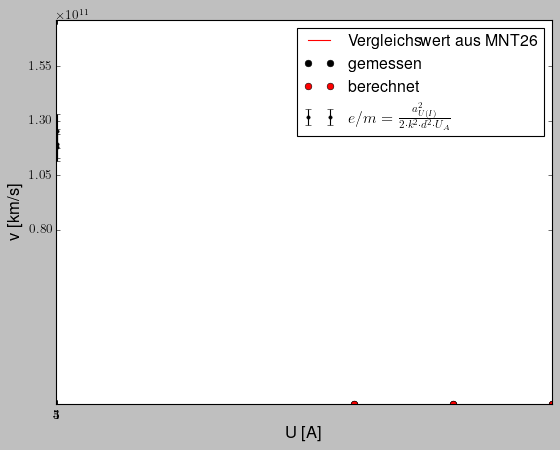

In [94]:
xx_8 = np.array([3e3, 4e3,5e3])
yy_ber = np.array([v1, v2,v3])
yy_real = np.array([v_real1, v_real2, v_real3])
plt.plot(xx_8,yy_ber,'ko',label='gemessen')
plt.plot(xx_8,yy_real,'ro', label='berechnet')
plt.legend()
plt.xlabel('U [A]')
plt.ylabel('v [km/s]')
plt.show()

## relativistische Korrektur

In [95]:
c = 3e8

In [96]:
print(round(v1/299792458*100,2),'%')
print(round(v2/299792458*100,2),'%')
print(round(v3/299792458*100,2),'%')

8.87 %
10.56 %
11.52 %


In [97]:
xx_8 = np.array([3, 4,5])
yy_berc = np.array([v1, v2,v3])/299792458 * 100
yy_realc = np.array([v_real1, v_real2, v_real3])/299792458 *100
plt.plot(xx_8,yy_berc,'ko',label='gemessen')
plt.plot(xx_8,yy_realc,'ro', label='berechnet')
plt.legend()
plt.xlabel('U [kV]')
plt.ylabel(r'relativistische Korrektur [$\%$]')
plt.xticks([3,4,5])
plt.yticks(np.arange(7,14.1,1.75))

([<matplotlib.axis.YTick at 0x1c595e27e60>,
 [Text(0, 7.0, '$\\mathdefault{7.00}$'),
  Text(0, 8.75, '$\\mathdefault{8.75}$'),
  Text(0, 10.5, '$\\mathdefault{10.50}$'),
  Text(0, 12.25, '$\\mathdefault{12.25}$'),
  Text(0, 14.0, '$\\mathdefault{14.00}$')])

# Aufgabe 9
Beide zur Bestimmung der spezifischen Elektronenladung eingesetzte Methoden sind miteinander
kritisch zu vergleichen und dabei auftretende Messabweichungen bzw. Unsicherheiten mit
ihrer Wirkung auf das Endergebnis zu betrachten und zu bewerten. Welche Bedingungen und
Größen erweisen sich jeweils als kritisch für das Experiment? Welche Vor- und Nachteile lassen
sich für die beiden Verfahren feststellen? Was könnte wie verbessert werden?